# Filter posts on the reddit related to the QAnon

python=3.7.16

2016 POTUS Election (time：April 1, 2020 to April 30 2021)

In [1]:
import pandas as pd
from joblib import Parallel, delayed  # parallel computing
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# show all columns in the DataFrame
pd.set_option('display.max_columns', None)
# fully display the content in displayed table cells
pd.set_option('display.max_colwidth', None)

## Use keywords to select comments related to QAnon

In [ ]:
import os
from datetime import datetime

topic_keywords = ['QAnon']

source_path = "/mnt/data/reddit/reddit/RC/"
target_path = "data/csv[keyword=QAnon]/"

# setting time range
start_date = datetime.strptime("2020-04", "%Y-%m")
end_date = datetime.strptime("2021-04", "%Y-%m")

# go through files in the directory, and process the files in the time range
for filename in os.listdir(source_path):
    # check file name: "RC_YYYY-MM.zst.csv"
    if filename.startswith("RC_") and filename.endswith(".zst.csv"):
        # get date from file name
        date_str = filename[3:10]
        file_date = datetime.strptime(date_str, "%Y-%m")
        
        # check if the date in time range. if yes, process the file.
        if start_date <= file_date <= end_date:
            print(filename)
            df = pd.read_csv(source_path + filename)
            df = df[df['body'].astype(str).str.contains('|'.join(topic_keywords), case=False)]
            df.to_csv(target_path + f"{date_str}.csv", index=False)

## Based on previous selection, use debunking keywords for filtering

In [5]:
# English debunking keywords
df = pd.read_csv("data/comments[keyword=QAnon].csv")

debunk_keywords_en = [
    'fact check', 'fact-checking', 'fact checkers', 'fake news', 'misinformation', 'disinformation', 
    'debunkers', 'debunker', 'debunking', 'debunk'
]

# get more debunking key words
debunk_site = pd.read_csv("data/(Merge_ver3)debunking_fact-checking_sites.csv")
debunk_site = debunk_site.dropna(subset=['domain'])
debunk_site_domain = debunk_site['domain'].to_list()
debunk_site_name = debunk_site['name'].to_list()

df_debunk_en = df[
    (df['lang'] == 'en') &  # '&' has higher priority than '=='
    df['body'].astype(str).str.contains('|'.join(debunk_keywords_en + debunk_site_domain + debunk_site_name), case=False)
]

df_debunk_en.sort_values('created_utc', inplace=True)
df_debunk_en.to_csv("data/debunking_comments[keyword=QAnon][lang=en].csv", index=False)

In [29]:
df_debunk_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 14 to 123881
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   created_utc   14637 non-null  object
 1   author        14637 non-null  object
 2   subreddit     14637 non-null  object
 3   body          14637 non-null  object
 4   parent_id     14637 non-null  object
 5   subreddit_id  14637 non-null  object
 6   id            14637 non-null  object
 7   lang          14637 non-null  object
dtypes: object(8)
memory usage: 1.0+ MB


In [ ]:
import pandas as pd

df = pd.read_csv("data/debunking_comments[keyword=QAnon][lang=en].csv")

df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date  

date_range = pd.date_range(start=df['date'].min(), end=df['date'].max()) 
date_range

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25',
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-01'],
              dtype='datetime64[ns]', length=396, freq='D')

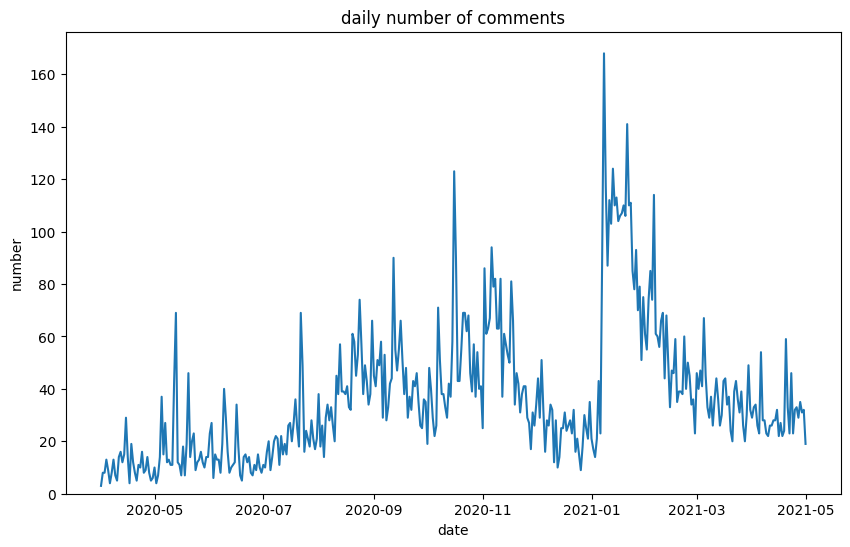

In [ ]:

df = pd.read_csv("data/debunking_comments[keyword=QAnon][lang=en].csv")

df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date 


date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

daily_counts = df.groupby('date').size()  

daily_counts = daily_counts.reindex(date_range, fill_value=0)

plt.figure(figsize=(10, 6))

sns.lineplot(data=daily_counts)

plt.title('daily number of comments')
plt.ylim((0,None))
plt.xlabel('date')
plt.ylabel('number')
plt.show()